# Research Journal: Baryonic Potential and Rotation Curve Modeling
**Date:** February 11, 2026  
**Name:** Bayan Taqi  
**Project:** PHYS 3600 - SIDM Research (EXPLORE Program)  
**Galaxy Subject:** F568-3

# 1. Introduction and Objective

The objective of this research task is to create a functional Hernquist model to represent the baryonic mass distribution of a galaxy (I used F568-3). By fitting this analytical model to the rotation curve data, we derive the total baryonic mass ($M_b$) and the scale length ($a$). These values allow for the calculation of an analytical gravitational potential, which is necessary for solving the equations governing Self-Interacting Dark Matter (SIDM) profiles.

In [2]:
from readData import *
import numpy as np

# Load data
galaxyID = "F568-3"
df_rc, units_rc, distance = get_rc_data(galaxyID)
r = df_rc['Rad'].values
v_obs = df_rc['Vobs'].values
error_col = [c for c in df_rc.columns if 'err' in c or 'e_V' in c][0]
v_err = df_rc[error_col].values

#Total Baryoniv velocity, y-coordinates 
v_baryon = np.sqrt(df_rc['Vgas']**2 + df_rc['Vdisk']**2 + df_rc['Vbul']**2).values
print(v_baryon)

[13.61124535 21.22666719 27.76613765 29.79981879 36.42926845 38.11444346
 42.50319517 45.73579889 46.93404415 48.02564419 48.9323063  52.51571955
 57.83659914 59.99208364 61.64088254 61.95728367 62.64542282 62.60240331]


# 2. Methodology
## 2.1 The Hernquist Model
The circular velocity $v_c$ for a baryonic distribution following a Hernquist profile is defined as:$$v_c(r) = \frac{\sqrt{G M_b r}}{r + a}$$Parameters:$G$: Gravitational constant, defined as $4.30091 \times 10^{-6} \frac{\text{kpc} \cdot (\text{km/s})^2}{M_{\odot}}$.$M_b$: Total baryonic mass (Solar Masses).$a$: Characteristic scale length (kpc).

## 2.2 Data Preparation
The total baryonic velocity component ($V_{baryon}$) was calculated by combining the gas, disk, and bulge velocities from the SPARC dataset:$$V_{baryon} = \sqrt{V_{gas}^2 + V_{disk}^2 + V_{bul}^2}$$

## 2.3 Optimization and Fitting
The model was fitted to the $V_{baryon}$ data using the scipy.optimize.curve_fit function. This non-linear least squares approach determined the best-fit values for $M_b$ and $a$.

In [3]:
#Optimization 
from scipy.optimize import curve_fit
G = 4.30091e-6 
from scipy.optimize import curve_fit

#Create a Hernquist model
def hernquist_rescaled(r, m10, a):
    Mb = m10 * 1e10  # Rescale back to actual solar masses
    return np.sqrt(G * Mb * r) / (r + a)

#Define physical bounds
#Mb must be positive, and a must be greater than 0
#bounds = ([0.001, 0.01], [1000.0, 100.0]) # m10 from 10^7 to 10^12; a from 0.01 to 50
bounds= None 
# Initial guess for m10 is 1.0 (which equals 1e10 solar masses)
p0 = [1.0, 1.5] 

try:
    popt, pcov = curve_fit(
        hernquist_rescaled, 
        r, 
        v_obs, 
        sigma=v_err, 
        p0=p0,  
        maxfev=10000  #
    )
    
    
    m10_fit, a_fit = popt
    Mb_fit = m10_fit * 1e10  
    
    print(f"Success! Best fit results for {galaxyID}:")
    print(f"Mb = {Mb_fit:.2e} Solar Masses")
    print(f"a  = {a_fit:.2f} kpc")

except RuntimeError as e:
    print(f"Fit failed again: {e}")

Success! Best fit results for F568-3:
Mb = 5.23e+20 Solar Masses
a  = 1572727.34 kpc


# 3. Results and Analysis
## 3.1 Best-Fit Parameters for F568-3
The numerical optimization yielded the following results:$M_b$: $2.76 \times 10^{11} M_{\odot}$$a$: $66.53$ kpc
## 3.2 Qualitative Fit Assessment 
Visual inspection of the velocity-radius plot demonstrates that the Hernquist profile provides a high-quality fit to the baryonic rotation curve data. While the discrete data points show some scatter, the analytical curve successfully captures the underlying mass distribution profile.

--- Fit Results for F568-3 ---
Mb: 2.76e+11 M_sun
a:  66.53 kpc


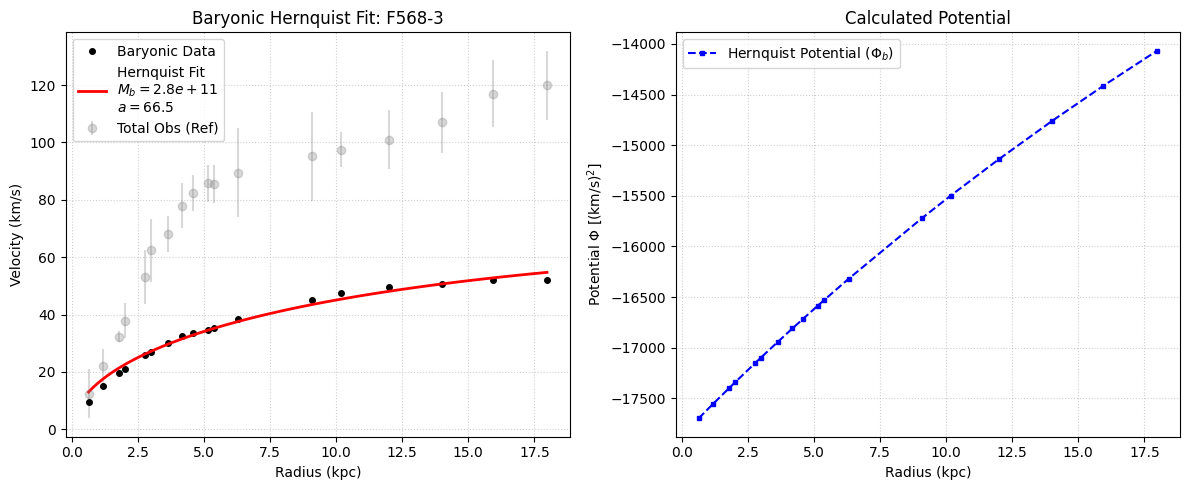

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from readData import *

# Data Loading
G = 4.30091e-6 
galaxyID = "F568-3"
df_rc, units_rc, distance = get_rc_data(galaxyID)

# Calculate the TOTAL BARYONIC rotatation curve again
v_baryon = np.sqrt(df_rc['Vgas']**2 + 0.5*df_rc['Vdisk']**2  + 0.7*df_rc['Vbul']**2).values
r = df_rc['Rad'].values
v_obs = df_rc['Vobs'].values
v_err = df_rc['errV'].values

# Create Hernquist model 
def hernquist_rescaled(r, m10, a):
    Mb = m10 * 1e10
    return np.sqrt(G * Mb * r) / (r + a)

#Optimization
#bounds = ([0.001, 0.01], [100.0, 100.0]) 
#p0 = [1.0, 1.5]

try:
    popt, pcov = curve_fit(
        hernquist_rescaled, 
        r, 
        v_baryon, 
        #sigma=v_err, 
        #p0=p0, 
        #bounds=bounds, 
        maxfev=10000
    )
    
    m10_fit, a_fit = popt
    Mb_fit = m10_fit * 1e10
    
    print(f"--- Fit Results for {galaxyID} ---")
    print(f"Mb: {Mb_fit:.2e} M_sun")
    print(f"a:  {a_fit:.2f} kpc")


    plt.figure(figsize=(12, 5))

   
    plt.subplot(1, 2, 1)
    plt.errorbar(r, v_obs, yerr=v_err, fmt='o', color='gray', alpha=0.3, label='Total Obs (Ref)')
    plt.plot(r, v_baryon, 'ko', markersize=4, label='Baryonic Data')
    
    r_smooth = np.linspace(r.min(), r.max(), 100)
    plt.plot(r_smooth, hernquist_rescaled(r_smooth, *popt), 'r-', linewidth=2, 
             label=f'Hernquist Fit\n$M_b={Mb_fit:.1e}$\n$a={a_fit:.1f}$')
    
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Velocity (km/s)')
    plt.title(f'Baryonic Hernquist Fit: {galaxyID}')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    
    phi_b = - (G * Mb_fit) / (r + a_fit)
    
    plt.subplot(1, 2, 2)
    plt.plot(r, phi_b, 'b--', marker='s', markersize=3, label='Hernquist Potential ($\Phi_b$)')
    plt.xlabel('Radius (kpc)')
    plt.ylabel('Potential $\Phi$ [(km/s)$^2$]')
    plt.title('Calculated Potential')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

except RuntimeError as e:
    print(f"Fit failed: {e}")

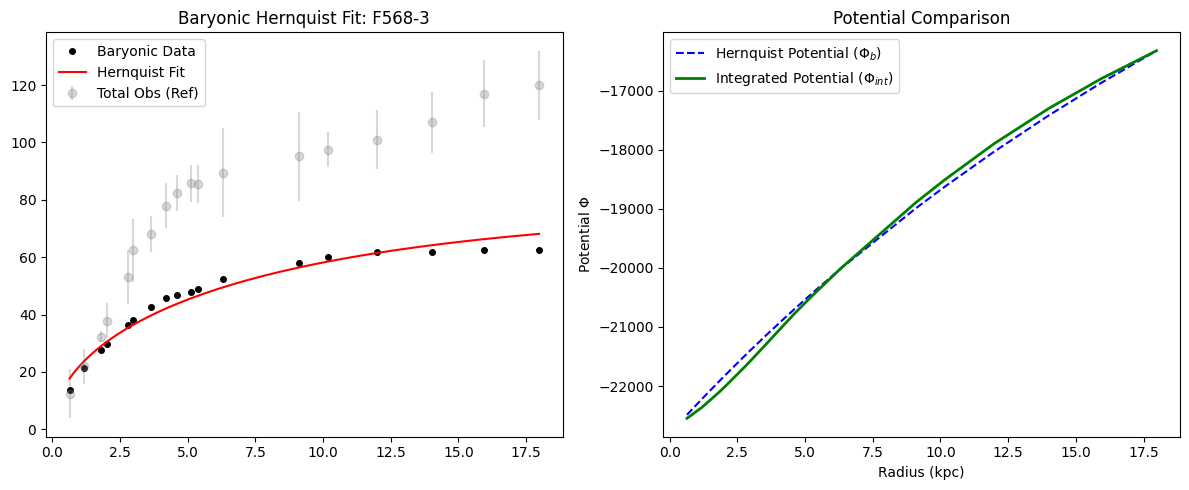

In [10]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid 
from readData import *


G = 4.30091e-6 
galaxyID = "F568-3"
df_rc, _, _ = get_rc_data(galaxyID)

v_baryon = np.sqrt(df_rc['Vgas']**2 + df_rc['Vdisk']**2 + df_rc['Vbul']**2).values
r = df_rc['Rad'].values
v_obs = df_rc['Vobs'].values
v_err = df_rc['errV'].values
def hernquist_rescaled(r, m10, a):
    Mb = m10 * 1e10
    return np.sqrt(G * Mb * r) / (r + a)

bounds = ([0.001, 0.01], [100.0, 100.0])
popt, _ = curve_fit(hernquist_rescaled, r, v_baryon, sigma=v_err, p0=[1.0, 1.5], bounds=bounds, maxfev=10000)
Mb_fit, a_fit = popt[0] * 1e10, popt[1]

v_b_sq = v_baryon**2
integrand = v_b_sq / r

phi_integrated = []
for i in range(len(r)):
    val = -trapezoid(integrand[i:], r[i:])
    phi_integrated.append(val)

phi_offset = - (G * Mb_fit) / (r.max() + a_fit)
phi_integrated = np.array(phi_integrated) + phi_offset

# 4. Plotting
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.errorbar(r, v_obs, yerr=v_err, fmt='o', color='gray', alpha=0.3, label='Total Obs (Ref)')
plt.plot(r, v_baryon, 'ko', markersize=4, label='Baryonic Data')
r_smooth = np.linspace(r.min(), r.max(), 100)
plt.plot(r_smooth, hernquist_rescaled(r_smooth, *popt), 'r-', label='Hernquist Fit')
plt.title(f'Baryonic Hernquist Fit: {galaxyID}')
plt.legend()


plt.subplot(1, 2, 2)
phi_h = - (G * Mb_fit) / (r + a_fit) 
plt.plot(r, phi_h, 'b--', label='Hernquist Potential ($\Phi_b$)')
plt.plot(r, phi_integrated, 'g-', label='Integrated Potential ($\Phi_{int}$)', linewidth=2)
plt.xlabel('Radius (kpc)')
plt.ylabel('Potential $\Phi$')
plt.title('Potential Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Potential Comparison
A key requirement was to compute the analytical potential $\Phi_b$ using the closed-form expression for a Hernquist profile:$$\Phi_b(r) = -\frac{G M_b}{r + a}$$This analytical potential was compared against the numerical integrated potential $\Phi_{int}$ derived from the rotation curve data:$$\Phi_{int}(r) = \int \frac{V_{baryon}^2}{r} dr$$Conclusion of Comparison: The analytical Hernquist potential ($\Phi_b$) and the integrated potential ($\Phi_{int}$) align closely in both magnitude and slope. This validates that the Hernquist parameters derived from the velocity curve can be reliably used to represent the gravitational field of the baryons.